# Lens modelling of DESJ0408-5354 with multiple options
This notebooks takes the data and psf configurations of the pre-analysis and configures (and runs) the lens modelling and parameter inference.
There are two modes:
    - local execution of a single model: this is mostly to test a model and having an output in a finite time. This is the default setting of this notebook.
    - cluster compute: it sends the configuration files to a cluster where the same models can be executed on multiple cores. This is the mode the results were produced.
    
In the second mode, the notebook initializes all the models that have been included in the analysis of [Shajib et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.6072S/abstract).
In the last blocks of the notebook, some quick model inspections are performed.

### import libraries

In [19]:
import lenstronomy

lenstronomy.__version__

'1.11.1'

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import lenstronomy
import numpy as np
import os
import pickle
import copy
import time
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import h5py
from pprint import pprint
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import LogFormatter 
import matplotlib.colors as colors

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
from lenstronomy.Util import param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import pickle
import joblib
import tqdm

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print(base_path)

/Users/pierreboccard/Doc/EPFL/PDM/Files


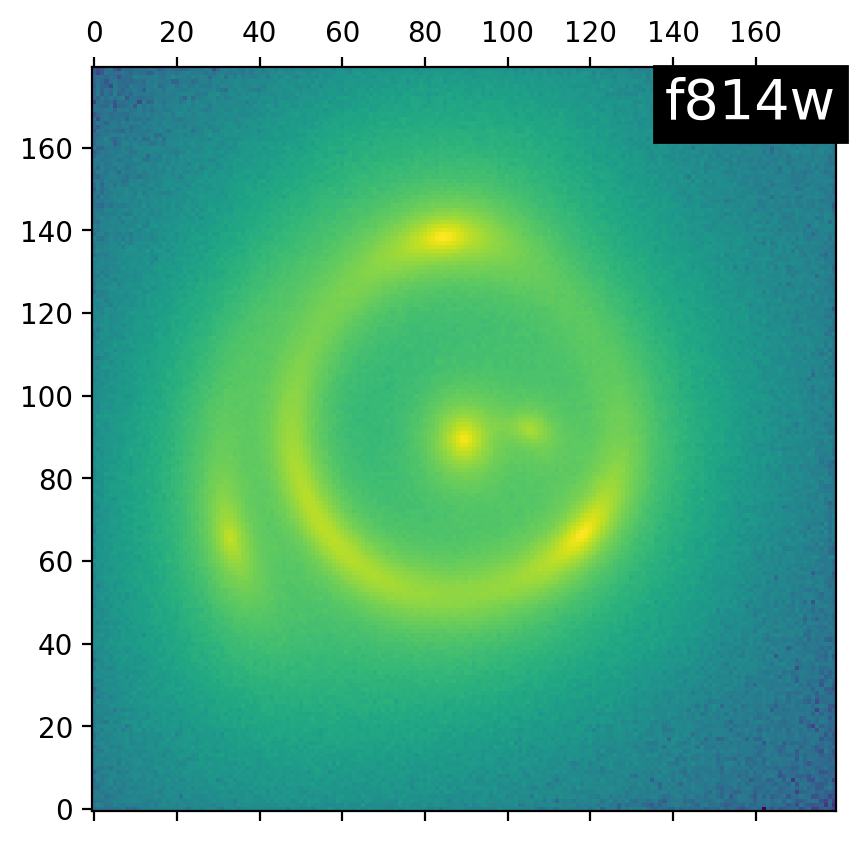

In [22]:
data814 = np.loadtxt('image_small.txt')
#data814 = np.loadtxt('image_sim_new814bis.txt')


plt.matshow(np.log10(data814), origin = "lower")
plt.text(138, 167, 'f814w', fontsize = 20, color = 'white',
         bbox = dict(facecolor = 'black', alpha = 1))
plt.show()


### set up the Data() and PSF() class of lenstronomy

In [23]:
def import_data(filter_name):
    """
    """
    #data_file = os.path.join(base_path, 'data', 'data_{}.hdf5'.format(filter_name))
    #f = h5py.File(data_file, 'r')

    if filter_name == 'f814w' :

        background_rms = .005  # background noise per pixel
        exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
        numPix = 180  # cutout pixel size
        deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
        fwhm = 0.15  # full width half max of PSF
        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
        data_class = ImageData(**kwargs_data)
        psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
        f = h5py.File(psf_file, 'r')
        kernel_point_source = f['kernel_point_source'][()]
        f.close()
        #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
        kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
        psf_class = PSF(**kwargs_psf)
        kwargs_data['image_data'] = data814
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

    return kwargs_data, kwargs_psf, coords

kwargs_data_f814w, kwargs_psf_f814w, coordsf814w = import_data('f814w')

print(kwargs_data_f814w['image_data'].shape)
print(kwargs_psf_f814w['kernel_point_source'].shape)


(180, 180)
(61, 61)


## show image and initial guesses of point source coordinates

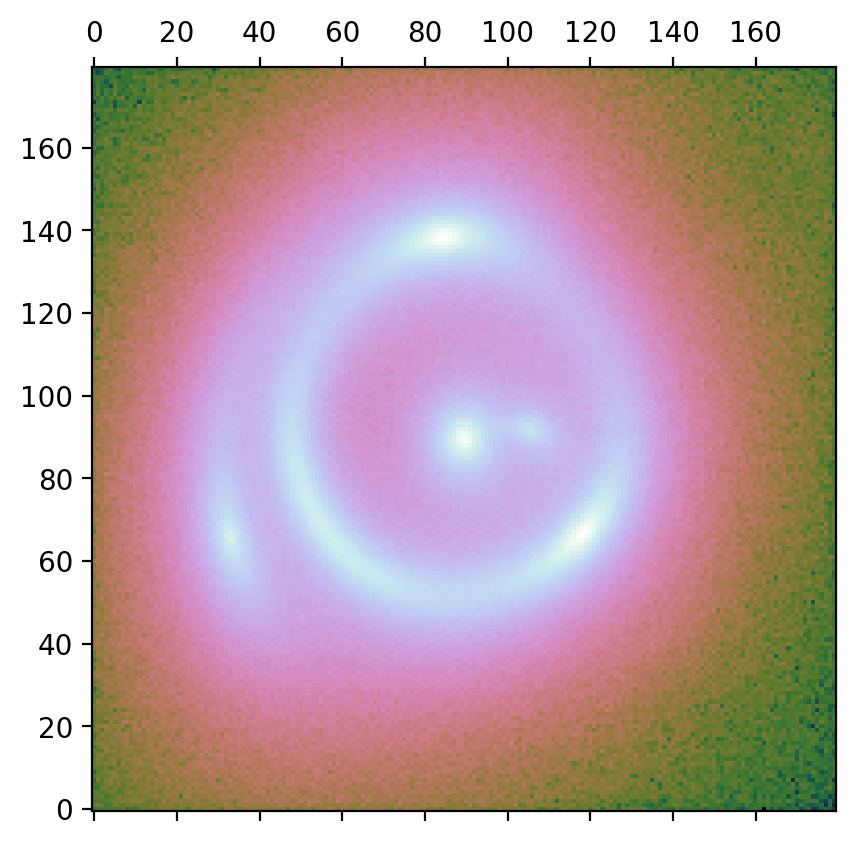

In [24]:
%matplotlib inline

# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_f814w['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_f814w['dec_at_xy_0']
transform_pix2angle = kwargs_data_f814w['transform_pix2angle']
coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

ra_at_xy_0 = kwargs_data_f814w['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_f814w['dec_at_xy_0']
transform_pix2angle = kwargs_data_f814w['transform_pix2angle']

cmap = "cubehelix"

# read-in the reduced cutout image
data_cutout = kwargs_data_f814w['image_data']
num_pix = len(data_cutout)

plt.matshow(np.log10(data_cutout), origin = "lower", cmap = cmap)

lens_center_ra, lens_center_dec = 0.0, 0.0

In [25]:
delta_pix = coords.pixel_width
print(delta_pix)
x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

0.05


### set the two masking regions used in the analysis

0.05


/var/folders/fs/pvtv8t8x15gbvc9qcpcjbtjm0000gn/T/ipykernel_2667/485319482.py:58: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=2, vmin=-4)


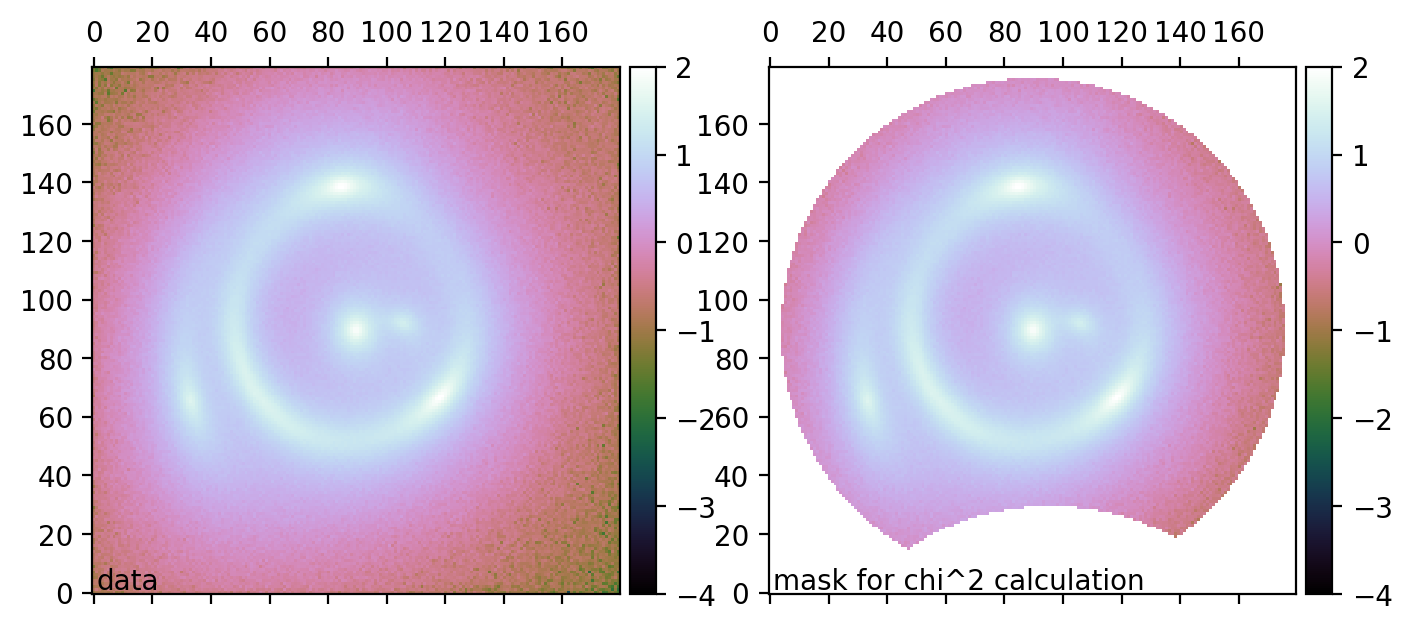

In [26]:
r_mask_list = [
    [4.3], #, 3.2] # f814w
]

mask_list = []
index_mask_list = []

for i in range(len(r_mask_list[0])):
    mask_bands = []
    index_mask_bands = []

    for j, kwargs_data in enumerate([kwargs_data_f814w]):
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
        num_pix = len(kwargs_data['image_data'])

        print(coords.pixel_width)
        
        x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)
        
        r = r_mask_list[j][i]
        
        mask_outer = mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r, util.image2array(x_coords), util.image2array(y_coords))
        index_mask = 1 - mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r+0.3, util.image2array(x_coords), util.image2array(y_coords))
        
        mask_ext1 = 1 - mask_util.mask_center_2d(lens_center_ra+0.2, lens_center_dec-4.3, 1., util.image2array(x_coords), util.image2array(y_coords))
        mask_ext2 = 1 - mask_util.mask_center_2d(lens_center_ra+0.3, lens_center_dec-7.4, 4.4, util.image2array(x_coords), util.image2array(y_coords))

        mask = (1 - mask_outer) * (1- mask_ext1) * (1 - mask_ext2)
        mask[mask >= 1] = 1
        mask[mask < 0] = 0
        
        mask_bands.append(array2image(mask))
        index_mask_bands.append(array2image(index_mask))
        
    mask_list.append(mask_bands)
    index_mask_list.append(index_mask_bands)

for j, kwargs_data in enumerate([kwargs_data_f814w]):
    image = kwargs_data['image_data']
    
    f, axes = plt.subplots(1, len(r_mask_list[j])+1, figsize=(8, 4), sharex=False, sharey=False)
    
    ax = axes[0]
    im = ax.matshow(np.log10(image), origin='lower', cmap=cmap, vmax=2, vmin=-4)
    ax.text(1, 1, 'data')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
        
    for i in range(len(mask_list)):
        ax = axes[i+1]
        
        mask = mask_list[i][j]
        im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=2, vmin=-4)
        ax.text(1, 1, 'mask for chi^2 calculation')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.show()

## supersampling mask

10


/var/folders/fs/pvtv8t8x15gbvc9qcpcjbtjm0000gn/T/ipykernel_2667/2737650202.py:21: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower')


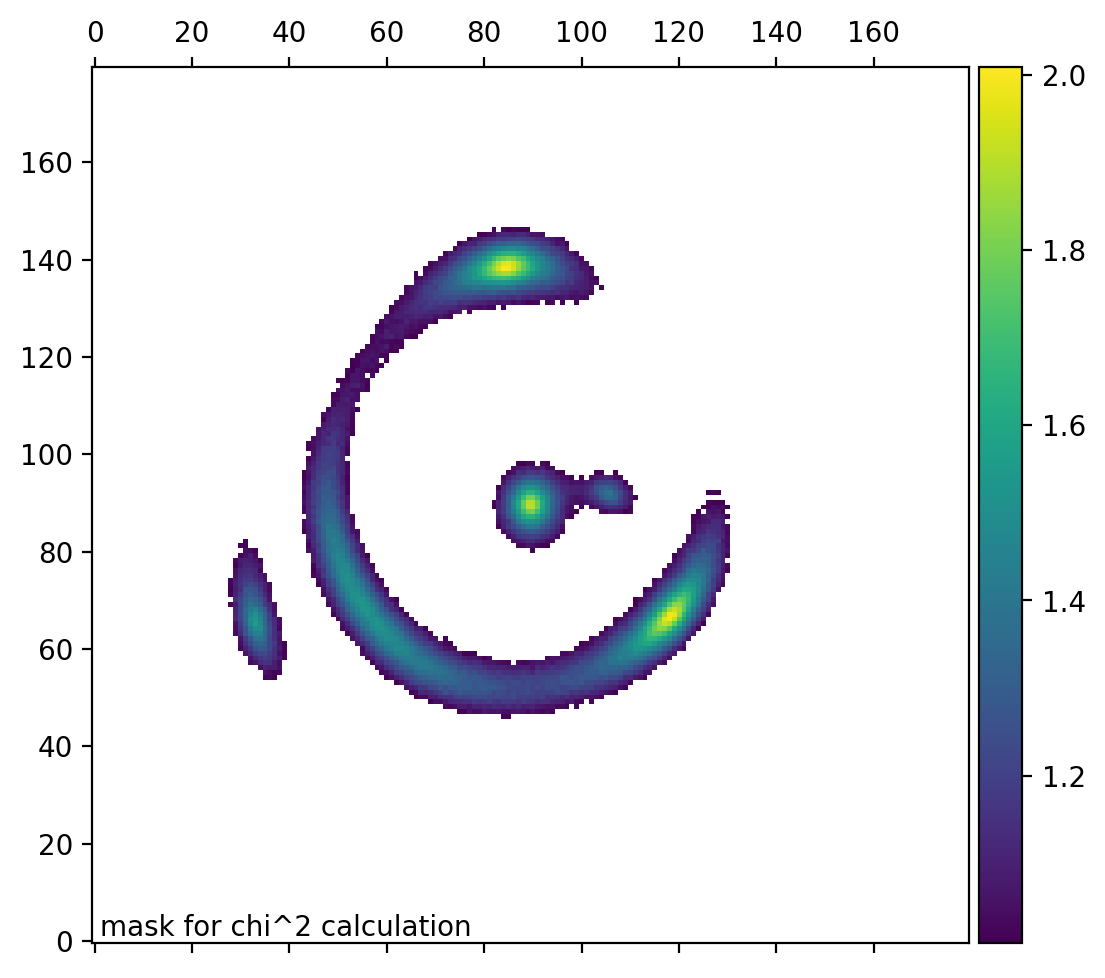

In [27]:
threshold = 10 #10**(5/2.5) # pixels with flux > max_flux/threshold will not be supersampled
print(threshold)

supersampling_mask = []

for j, kwargs_data in enumerate([kwargs_data_f814w]):
    s_mask = np.ones_like(kwargs_data['image_data'])
    
    max_flux = np.max(kwargs_data['image_data'])
    s_mask[kwargs_data['image_data'] < max_flux/threshold] = 0
    
    supersampling_mask.append(s_mask)

for j, kwargs_data in enumerate([kwargs_data_f814w]):
    image = kwargs_data['image_data']
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    mask = supersampling_mask[j]*mask_list[0][j]
    im = ax.matshow(np.log10(image*mask), origin='lower')
    ax.text(1, 1, 'mask for chi^2 calculation')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    plt.show()

## Source planes

In [28]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 

z_l = 0.597

z_s1 = 2.375
z_s2 = 2.228 #np.linspace(2.13, 2.42, 20)

D_s1 = cosmo.angular_diameter_distance(z_s1).value
D_s2 = cosmo.angular_diameter_distance(z_s2).value
D_ls1 = cosmo.angular_diameter_distance_z1z2(z_l, z_s1).value
D_ls2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s2).value

c = D_s2 * D_ls1 / D_s1 / D_ls2

print('deflection angle rescale factor: {:.6f}'.format(c))

deflection angle rescale factor: 1.021806


In [29]:
ssh_command = 'ajshajib@hoffman2.idre.ucla.edu'
dir_path = os.getcwd()
dir_path_cluster = '/u/flashscratch/a/ajshajib/'

## configure job

In [30]:
import pickle
import joblib

jobname = 'run0708-modellingsmall'


with open('known_solution_small_new.pickle', 'rb') as f:
    kwargs_result_old = pickle.load(f)

# with open('known_solution_small.pickle', 'rb') as f:
#     kwargs_result_old = pickle.load(f)

print(kwargs_result_old)
    
initiate_from_old_result = kwargs_result_old # or None

use_good_start = False
use_good_psf = False
power_law_good_start = '0408_run18_0_0_0_0_0_1_1_0'
reconstruct_psf = True
band_number = 1
do_mcmc = True

psf_iteration = True # bool, we perform an iterative PSF reconstruction
psf_iter_num = 200 # number of steps in the PSF reconstruction
psf_iter_factor = 0.5 # factor of f* new + (1-f)* old PSF in each iterative step
psf_symmetry = 4 # number of symmetry axis rotations

walker_ratio = 4

deflector_redshift = 0.597
front_galaxy_redshift = 2.228
front_galaxy_redshift2 = 0.780

ra_source1, dec_source1 = 0.2, 0.5
ra_source2, dec_source2 = -0.7, 0.0

do_multi_lens_plane = True

source_redshift = 2.375

def configure_model(job_name, 
                    mask=mask_list[0],
                    verbose=False, 
                    initiate_from_old_result=initiate_from_old_result,
                    distance_ratio_sampling=True
                   ):
    """
    this definitons takes as an input some specific options that are varried in the modelling and merges them
    with the other choices made and runs the modeling and parameter inference
    
    job_name: string, the file with its specific configuration will be named that way
    lens_model: string: 'composite', 'PEMD' as options
    perturber_model: string, type of model for the perturbers ('SIS', 'SIE', 'NFW', ...)
    mask: 2d numpy array, masking region of fit
    n_max: maximal polynomial order of shapelets in the source plane
    foreground_shear: bool, if True, adds a foreground shear model
    subgrid_res: subsampling of the surface brightness of pixels
    num_perturber: integer, number of perturbers being modeled (in subsequent order of the defined list above)
    group_halo: bool, additon an additonal group halo in addition to the main deflector
    cluser_compute: bool, if True, instead of running the chain, saves and copies the configuration files to a cluster
    """
    
    # print('\n')
    # print(kwargs_result_old)
    # print('\n')
    
    #  ======================================================  #
    #  SPECIFY PARAMETER CONSTRAINTS  #
    #  ======================================================  #

    #  ======================================================  #
    # lens models
    #  ======================================================  #
    fixed_lens = []
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []
    mass_scaling_list = []
    joint_lens_with_lens = []
    lens_model_list = []
    joint_lens_with_light = []
    lens_redshift_list = []
    observed_convention_index_list = []
    joint_lens_with_source_light = []
        
    
    lens_redshift_list.append(deflector_redshift)
    lens_model_list.append('EPL')
    kwargs_lens_init.append({'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.1})
    kwargs_lens_sigma.append({'theta_E': .1, 'e1':0.1, 'e2':0.1, 'gamma': 0.02, 
                            'center_x': 0.08, 'center_y': 0.08})
    kwargs_lower_lens.append({'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.50, 
                             'center_x': lens_center_ra-0.5, 'center_y': lens_center_dec-0.5})
    kwargs_upper_lens.append({'theta_E': 3, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 
                             'center_x': lens_center_ra+0.5, 'center_y': lens_center_dec+0.5})
    fixed_lens.append({})


    lens_model_list.append('SIS')
    lens_redshift_list.append(front_galaxy_redshift)
    kwargs_lens_init.append({'theta_E': 0.1, 'center_x': ra_source2, 'center_y': dec_source2})
    kwargs_lens_sigma.append({'theta_E': .01, 'center_x': 0.08, 'center_y': 0.08})
    kwargs_lower_lens.append({'theta_E': 0.01, 'center_x': ra_source2-0.5, 'center_y': dec_source2-0.5})
    kwargs_upper_lens.append({'theta_E': 0.5, 'center_x': ra_source2+0.5, 'center_y': dec_source2+0.5})
    fixed_lens.append({})


    ra_lensnew, dec_lensnew = 3.5, 3.0
    lens_model_list.append('SIS')
    lens_redshift_list.append(front_galaxy_redshift2)
    kwargs_lens_init.append({'theta_E': 0.5, 'center_x': ra_lensnew, 'center_y': dec_lensnew})
    kwargs_lens_sigma.append({'theta_E': .01, 'center_x': 0.08, 'center_y': 0.08})
    kwargs_lower_lens.append({'theta_E': 0.1, 'center_x': ra_lensnew-0.5, 'center_y': dec_lensnew-0.5})
    kwargs_upper_lens.append({'theta_E': 0.8, 'center_x': ra_lensnew+0.5, 'center_y': dec_lensnew+0.5})
    fixed_lens.append({})       
     

    special_params = [{'scale_factor': [1., .2], 
                          'tau0_list': [1]}, 
                         {'scale_factor': [.1, .02], 
                          'tau0_list': [.5]}, 
                         {}, 
                         {'scale_factor': [.5, 0.01], 
                          'tau0_list': [0.1]}, 
                         {'scale_factor': [2.5, 2.], 
                          'tau0_list': [2.0]}
                        ]

    # fixed_lens = kwargs_lens_init #FIXING

    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


    #  ======================================================  #
    # lens light models
    #  ======================================================  #
    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []
    joint_lens_light_with_lens_light = []
    lens_light_model_list = []
    lens_light_indices = [[]]

    lens_light_model_list_template = ['SERSIC_ELLIPSE']

    lens_bound = 0.1

    for band_num in range(band_number):
        for i, model in enumerate(lens_light_model_list_template):
            
            # if (i == 0 and band_num == 0) :
            #     pass

            lens_light_model_list.append(model) 
            fixed_lens_light.append({})
            kwargs_lens_light_init.append({'amp': 500, 'R_sersic': 1.3, 'n_sersic': 5, 'e1': -0.1, 'e2': 0., 'center_x': 0., 'center_y': 0.})
            kwargs_lens_light_sigma.append({'center_x': delta_pix, 'center_y': delta_pix, 'R_sersic': 0.05, 'n_sersic': 0.5, 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_lens_light.append({'R_sersic': 0.01, 'n_sersic': 0.5, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound, 'e1': -0.3, 'e2': -0.2})
            kwargs_upper_lens_light.append({'R_sersic': 5., 'n_sersic': 8, 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound, 'e1': 0.1, 'e2': 0.2})

            lens_light_indices[band_num].append(len(lens_light_model_list)-1)


    #fixed_lens_light = kwargs_lens_light_init #FIXING
            
    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

    
    #  ======================================================  #
    # source light models
    #  ======================================================  #
        
    fixed_source = []
    kwargs_source_init = []
    kwargs_source_sigma = []
    kwargs_lower_source = []
    kwargs_upper_source = []
    joint_source_with_point_source = []
    joint_source_with_source = []
    image_plane_source_list = []

    source_light_model_list = []
    source_light_indices = [[]]
    
    i_ps = 0

    source_light_model_list_template = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

    source_redshift_list = [2.375, 2.228]#, 2.375, 2.228, 2.375, 2.228]

    source_bound = 0.2
    
    for band_num in range(band_number):
        for i, model in enumerate(source_light_model_list_template):

            if i == 0 : 
                ra_source = ra_source1
                dec_source = dec_source1

            if i == 1 : 
                ra_source = ra_source2
                dec_source = dec_source2
       

            source_light_model_list.append(model)
          
            image_plane_source_list.append(False)
        
            kwargs_source_init.append({'amp': 400., 
                                       'R_sersic': 1., 
                                       'n_sersic': 5, 
                                       'center_x': ra_source, 
                                       'center_y': dec_source, 
                                       'e1': -0.1, 'e2': 0.1})

            kwargs_lower_source.append({'n_sersic': 1, 
                                        'R_sersic': 0.1,
                                        'center_y': dec_source - source_bound, 
                                        'center_x': ra_source - source_bound,
                                        'e1': -0.3,
                                        'e2': -0.1})

            kwargs_upper_source.append({'n_sersic': 8, 
                                        'R_sersic': 2, 
                                        'center_y': dec_source + source_bound, 
                                        'center_x': ra_source + source_bound,
                                        'e1': 0.1,
                                        'e2': 0.3})
            
            kwargs_source_sigma.append({'center_x': 0.01, 
                                        'center_y': 0.01, 
                                        'R_sersic': 0.005,
                                        'n_sersic': 0.5, 
                                        'e1': 0.05, 'e2': 0.05})

            fixed_source.append({})

            source_light_indices[band_num].append(len(kwargs_source_init) - 1)


    # fixed_source = kwargs_source_init #FIXING

    source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]
    
    #  ======================================================  #
    # optical depth model
    #  ======================================================  #

    #fixed_extinction = [{'amp': 0.0}, {'amp': 0.0}, {'amp': 0.0}]

    optical_depth_model_list = ['SERSIC']#, 'SERSIC', 'SERSIC']
    index_optical_depth_model_list = [[0]]#, [1], [2]]
    joint_extinction_with_lens_light = []

    # joint_extinction_with_lens_light = [[len(lens_light_model_list)-3, 0, ['R_sersic', 'n_sersic', 'center_x', 'center_y']],
    #                                     [len(lens_light_model_list)-3, 1, ['R_sersic', 'n_sersic', 'center_x', 'center_y']],
    #                                     [len(lens_light_model_list)-3, 2, ['R_sersic', 'n_sersic', 'center_x', 'center_y']]]

    kwargs_extinction_init = [
    #{'amp': 0, 'R_sersic': 0.005, 'n_sersic': 1, 'center_x': 0, 'center_y': 0}, 
    #{'amp': 0, 'R_sersic': 0.005, 'n_sersic': 1, 'center_x': 0, 'center_y': 0},
    {'amp': 0, 'R_sersic': 0.005, 'n_sersic': 1, 'center_x': 0, 'center_y': 0}]

    #kwargs_extinction_init = fixed_extinction
    fixed_extinction = kwargs_extinction_init
    kwargs_extinction_sigma = [{'amp': 0, 'R_sersic': 0.001, 'n_sersic': 0.01, 'center_x': 0.01, 'center_y': 0.01}]#, {}, {}]
    kwargs_lower_extinction = [{'amp': 0, 'R_sersic': 0.001, 'n_sersic': 0.1, 'center_x': -0.1, 'center_y': -0.1}]#, {}, {}]
    kwargs_upper_extinction = [{'amp': 0, 'R_sersic': 0.01, 'n_sersic': 3, 'center_x': 0.1, 'center_y': 0.1}]#, {}, {}]
    extinction_params = [kwargs_extinction_init, kwargs_extinction_sigma, fixed_extinction, kwargs_lower_extinction, kwargs_upper_extinction]

    
    #  ======================================================  #
    #  GOOD Initializer
    #  ======================================================  #
    
    def update_inits(frm, to, position_off=False):
            for i, (f, t) in enumerate(zip(frm, to)):
                for key, value in f.items():
                    if key in t: # and key not in ['theta_E']:
                        if key in ['center_x', 'center_y']:
                            # print('\n')
                            # print(image_plane_source_list)
                            # print(position_off)
                            if not position_off or not image_plane_source_list[i]:
                                # print('\n')
                                # print(t)
                                # print(key)
                                # print(t[key])
                                # print('\n')
                                t[key] = value
                        else:
                            t[key] = value          
            return to

    def update_upper_lower(params):
        kwargs_params = params[0]
        sigma_params = params[1]
        lower_params = params[3]
        upper_params = params[4]

        f = .5

        for i, (kp, sig) in enumerate(zip(kwargs_params, sigma_params)):
            for key, value in sig.items():
                if key in lower_params[i]:
                    lower_params[i][key] = max(lower_params[i][key], kp[key] - f*sig[key])
                    upper_params[i][key] = min(upper_params[i][key], kp[key] + f*sig[key])

        return lower_params, upper_params
    
    def check_upper_lower(params):
        kwargs_params = params[0]
        sigma_params = params[1]
        lower_params = params[3]
        upper_params = params[4]

        f = .5

        for i, (kp, sig) in enumerate(zip(kwargs_params, sigma_params)):
            for key, value in sig.items():
                if key in lower_params[i]:
                    if not lower_params[i][key] <= kwargs_params[i][key] <= upper_params[i][key]:
                        print(i, key, lower_params[i][key], kwargs_params[i][key], upper_params[i][key])
    
    
    if initiate_from_old_result is not None:
        
        lens_result = initiate_from_old_result['kwargs_lens']
        source_result = initiate_from_old_result['kwargs_source']
        lens_light_result = initiate_from_old_result['kwargs_lens_light']
        
        lens_params[0] = update_inits(lens_result, lens_params[0])
        source_params[0] = update_inits(source_result, source_params[0], position_off=True)
        lens_light_params[0] = update_inits(lens_light_result, lens_light_params[0])


    #fixed_lens = lens_params[0]

    special_params = [{'scale_factor': [1., .2], 
                       'tau0_list': [1]
                      }, 
                      {'scale_factor': [.1, .02], 
                      'tau0_list': [.5]}, 
                      {}, 
                      {'scale_factor': [.5, 0.01], 
                       'tau0_list': [0.1]}, 
                      {'scale_factor': [2.5, 2.], 
                        'tau0_list': [2.0]}
                     ]

    if distance_ratio_sampling: ## this is new
        
        # initial values

        special_params[0]['a_1'] = 1.2
        special_params[0]['a_2'] = 1.2
        
        
        # sigma 
        special_params[1]['a_1'] = 0.1
        special_params[1]['a_2'] = 0.1
        
        
        # lower limit
        special_params[3]['a_1'] = 0.5
        special_params[3]['a_2'] = 0.5
        

        
        # upper limit
        special_params[4]['a_1'] = 1.5
        special_params[4]['a_2'] = 1.5
        

        # complex 

        special_params[0]['a_3'] = 1.2
        special_params[0]['b_2'] = 1.2
        special_params[1]['a_3'] = 0.1
        special_params[1]['b_2'] = 0.1
        special_params[3]['a_3'] = 0.5
        special_params[3]['b_2'] = 0.5
        special_params[4]['a_3'] = 1.5
        special_params[4]['b_2'] = 1.5
    
    kwargs_params = {'lens_model': lens_params,
                     'source_model': source_params,
                     'lens_light_model': lens_light_params,
                     'special': special_params,
                     'extinction_model': extinction_params,
                    }

    #  ======================================================  #
    #  CHECK PARAMETERS  #
    #  ======================================================  #

    #  ======================================================  #
    #  SPECIFY MODEL OPTIONS  #
    #  ======================================================  #

    # Copied from simulation
    kwargs_model = {'lens_model_list': lens_model_list,
                    'source_light_model_list': source_light_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'index_lens_light_model_list': lens_light_indices,
                    'index_source_light_model_list': source_light_indices,
                    'distance_ratio_sampling': distance_ratio_sampling,
                    'multi_plane': do_multi_lens_plane,
                    'lens_redshift_list': lens_redshift_list,
                    'cosmo': cosmo,
                    'z_source': source_redshift,
                    'source_redshift_list': source_redshift_list,
                    }

    num_source_model = len(source_light_model_list)
    
    kwargs_constraints = {
                    'joint_lens_with_lens': joint_lens_with_lens,
                    'joint_lens_with_light': joint_lens_with_light,
                    'joint_lens_light_with_lens_light': joint_lens_light_with_lens_light,
                    'joint_source_with_source': joint_source_with_source,
                    'joint_extinction_with_lens_light': joint_extinction_with_lens_light,
                    'joint_lens_with_source_light':joint_lens_with_source_light,
                    'mass_scaling_list': mass_scaling_list,
                    'num_tau0': 1,
                    'image_plane_source_list': image_plane_source_list}
    
    kwargs_likelihood = {'force_no_add_image': False,
                         'source_marg': True,
                         'linear_prior': 5e4,
                         'image_position_uncertainty': 0.00004,
                         'check_matched_source_position': False,
                         'source_position_tolerance': 0.001,
                         'check_positive_flux': True, # False
                         'check_bounds': True,
                         'bands_compute': [True, True, True],
                         'image_likelihood_mask_list': mask, 
                        }

    multi_band_list = []
    
    #for i, (kwargs_data, kwargs_psf) in enumerate(zip([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w], [kwargs_psf_f814w, kwargs_psf_f475x, kwargs_psf_f160w])):
    for i, (kwargs_data, kwargs_psf) in enumerate(zip([kwargs_data_f814w], [kwargs_psf_f814w])):
        
        kwargs_numerics_band = {'supersampling_factor': 1,
                                'supersampling_convolution': False}
        if use_good_psf:
            kwargs_psf = multi_band_list_out[i][1]
            kwargs_data = multi_band_list_out[i][0]

        band_list = [kwargs_data, kwargs_psf, kwargs_numerics_band]
        
        multi_band_list.append(band_list)
    
    # kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'} WARNING
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'single-band'}
   
    #  ======================================================  #
    #  SPECIFY A FITTING SEQUENCE  #
    #  ======================================================  #

    if verbose:
        print('lens model list:', lens_model_list)
        print('lens model init params:', lens_params[0])
        print('kwargs_model:', kwargs_model)
        print('lens model list:', lens_model_list)
        print('lens redshift list:', lens_redshift_list)
        print('observed convention index list', observed_convention_index_list)
        print('joint lens with lens:', joint_lens_with_lens)
        print('mass scaling list:', mass_scaling_list)
        print('special params:', special_params)
        print('joint lens with source', joint_lens_with_source_light)
        print('')
        print('lens light model list:', lens_light_model_list)
        print('lens light indices:', lens_light_indices)
        print('joint lens light with lens:', joint_lens_with_light)
        print('joint lens light with lens light:', joint_lens_light_with_lens_light)
        print('source light model list:', source_light_model_list)
        print('source light indices:', source_light_indices)
        print('image_plane_source_list:', image_plane_source_list)
        print('joint source with source:', joint_source_with_source)
        print('joint source with point source:', joint_source_with_point_source)
        print('source redshift list', kwargs_model['source_redshift_list'])
        print('cosmo', cosmo)
    
    def fix_profile_params(band_list):
        fix_param_list = []
        
        for b in band_list:
            lens_light_index = lens_light_indices[b]
            
            for index in lens_light_index:
                for key in lens_light_params[0][index]:
                    if key not in ['n_max']:
                        fix_param_list.append(['update_settings', {'lens_light_add_fixed': [[index, [key]]]}])
                        
            source_light_index = source_light_indices[b]
            
            for index in source_light_index:
                for key in source_params[0][index]:
                    if key not in ['n_max']:
                        fix_param_list.append(['update_settings', {'source_add_fixed': [[index, [key]]]}])
                        
            if verbose:
                print('')
                pprint(fix_param_list)
                
            return fix_param_list
        
    def unfix_profile_params(band_list):
        unfix_param_list = []
        
        for b in band_list:
            lens_light_index = lens_light_indices[b] 
            
            for index in lens_light_index:
                for key in lens_light_params[0][index]:
                    if key not in ['n_max']:
                        unfix_param_list.append(['update_settings', {'lens_light_remove_fixed': [[index, [key]]]}])
                        
            source_light_index = source_light_indices[b] # kwargs_data_joint['multi_band_list'][b][-1]['index_source_light_model']
            
            for index in source_light_index:
                for key in source_params[0][index]:
                    if key not in ['n_max']:
                        unfix_param_list.append(['update_settings', {'source_remove_fixed': [[index, [key]]]}])
                        
            if verbose:
                print('')
                #print('unfix_profile_params')
                pprint(unfix_param_list)
                
            return unfix_param_list
        
    fitting_kwargs_list = []
    
    fitting_kwargs_list += [#['update_settings', {'cosmo_add_fixed': ['a_1', 'a_2']}],
                            ['update_settings', {'cosmo_add_fixed': ['a_1', 'a_2', 'a_3', 'b_2']}],
                           ]
    
    if reconstruct_psf:

        n_part = 10
        n_iter = 10
        nb_thread = 8

        fitting_kwargs_list += [

            #['update_settings', {'cosmo_remove_fixed': ['a_1', 'a_2']}],
            ['update_settings', {'cosmo_remove_fixed': ['a_1', 'a_2', 'a_3', 'b_2']}],

            #['PSO', {'sigma_scale': 1., 'n_particles': n_part, 'n_iterations': n_iter, 'threadCount': nb_thread}],

            # ['PSO', {'sigma_scale': 1., 'n_particles': n_part, 'n_iterations': n_iter, 'threadCount': nb_thread}],
        ] 

        fitting_kwargs_list += [['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, True]}}]]

        # fitting_kwargs_list += [
        #     ['align_images', {'n_particles': n_part, 'n_iterations': n_iter, 'compute_bands': [False, False, True]}],
            
        #     ['PSO', {'sigma_scale': 1., 'n_particles': n_part, 'n_iterations': n_iter, 'threadCount': nb_thread}],
            
        #     ['align_images', {'n_particles': n_part, 'n_iterations': n_iter, 'compute_bands': [False, False, True]}],

        #     ['PSO', {'sigma_scale': 1., 'n_particles': n_part, 'n_iterations': n_iter, 'threadCount': nb_thread}],

        #     ['align_images', {'n_particles': n_part, 'n_iterations': n_iter, 'compute_bands': [False, False, True]}],
            
        #     ['PSO', {'sigma_scale': 1., 'n_particles': n_part, 'n_iterations': n_iter, 'threadCount': nb_thread}],
            
        #     ['PSO', {'sigma_scale': .1, 'n_particles': n_part, 'n_iterations': n_iter, 'threadCount': nb_thread}],
        # ]

        # if deflector_model == 'EPL':
        #     fitting_kwargs_list += [['update_settings', {'lens_remove_fixed': [[0, ['gamma']]]}]]
        
        # fitting_kwargs_list += [
            
        #     ['PSO', {'sigma_scale': 1., 'n_particles': n_part, 'n_iterations': n_iter, 'threadCount': nb_thread}],

        #     ['PSO', {'sigma_scale': .1, 'n_particles': n_part, 'n_iterations': n_iter, 'threadCount': nb_thread}],
        # ]
 
    
    if do_mcmc is True:
       fitting_kwargs_list.append(['MCMC', {'n_burn': 0, 'n_run': 10, 'threadCount': 8,
                                   'walkerRatio': walker_ratio, 'sigma_scale': 0.01,
                                   'progress': True, 'backend_filename' : '/Users/pierreboccard/Doc/EPFL/PDM/Files/notebooks/figures/Local/modellingsmallnew/run0708-mcmc-freecosmo/savingmcmcrun0708-mcmc-freecosmo', #/Users/pierreboccard/Doc/EPFL/PDM/Files/notebooks/figures/Local/modellingsmall/run0615-mcmc-freecosmo/
                                   'start_from_backend' : True}])
    
    if verbose:
        print("fitting_kwargs_list:")
        print(fitting_kwargs_list)

    init_samples = None
    input_temp = job_name +'.txt'
    output_temp = job_name +'_out.txt'
    
    path2input_temp = os.path.join(base_path, 'temp', input_temp)

    f = open(path2input_temp,'wb')

    pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
    f.close()
    time.sleep(2)

    start_time = time.time()
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False, verbose=True)

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

    fit_output = chain_list

    [param_list, samples_mcmc, param_mcmc, dist_mcmc] = chain_list[0]

    kwargs_result = fitting_seq.best_fit(bijective=False)

    multi_band_list_out = fitting_seq.multi_band_list
    
    kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs
    
    #output_ = [kwargs_result, multi_band_list_out, fitting_seq, mask_list, kwargs_fixed_out, chain_list]
    output_ = [kwargs_result, multi_band_list_out, fitting_seq, mask_list, kwargs_fixed_out, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc]
    input_ = [fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]

    
    path2dump = os.path.join(base_path, 'temp', output_temp)
    f = open(path2dump, 'wb')
    pickle.dump([input_, output_], f)
    f.close()
    end_time = time.time()
    print(end_time - start_time, 'total time needed for computation')
    print('Result saved in: %s' % path2dump)
    print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

    return fitting_seq, kwargs_params, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_numerics_band, chain_list

{'kwargs_lens': [{'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.1}, {'theta_E': 0.1, 'center_x': -0.7, 'center_y': 0.0}, {'theta_E': 0.5, 'center_x': 3.5, 'center_y': 3.0}], 'kwargs_source': [{'amp': 400.0, 'R_sersic': 1.0, 'n_sersic': 5, 'center_x': 0.2, 'center_y': 0.5, 'e1': -0.1, 'e2': 0.1}, {'amp': 400.0, 'R_sersic': 1, 'n_sersic': 3, 'center_x': -0.7, 'center_y': 0.0, 'e1': -0.2, 'e2': 0.2}], 'kwargs_lens_light': [{'amp': 500, 'R_sersic': 1.3, 'n_sersic': 5, 'e1': -0.1, 'e2': 0.0, 'center_x': 0.0, 'center_y': 0.0}], 'kwargs_ps': [], 'kwargs_extinction': [{'amp': 0, 'R_sersic': 0.005, 'n_sersic': 1, 'center_x': 0, 'center_y': 0}]}


### Local run

In [31]:
if True:
    job_name = jobname
    deflector_model = 0 #'SPEMD'  # 'composite', 'SPEMD'
    perturber_model = 1
    num_perturber = 4
    mask = mask_list[0]
    n_max = [4, 4, 7, 2]
    foreground_shear = False
    subgrid_res = 2
    
    fitting_seq, kwargs_params, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_numerics_band, chain_list = configure_model(
                    job_name, 
                    mask=mask_list[0],
                    verbose=False, 
                    initiate_from_old_result=initiate_from_old_result,
                    distance_ratio_sampling=True)
    

100%|██████████| 10000/10000 [1:45:05<00:00,  1.59it/s]


Computing the MCMC...
Number of walkers =  140
Burn-in iterations:  0
Sampling iterations (in current run): 10000
6312.360719203949 time taken for MCMC sampling
6319.731193065643 total time needed for computation
Result saved in: /Users/pierreboccard/Doc/EPFL/PDM/Files/temp/run0708-modellingsmall_out.txt
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


In [32]:
analyse_output = True

if analyse_output:
    job_name_out = jobname #job_name
    output_from_cluster = False
    input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()     
    
fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
#kwargs_result, multi_band_list_out, fitting_seq, mask_list, kwargs_fixed_out, chain_list = output_
kwargs_result, multi_band_list_out, fitting_seq, mask_list, kwargs_fixed_out, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = output_

In [33]:
lens_result, source_result, lens_light_result, ps_result, special_result = kwargs_result['kwargs_lens'], kwargs_result['kwargs_source'], kwargs_result['kwargs_lens_light'], kwargs_result['kwargs_ps'], kwargs_result['kwargs_special']
print('lens', lens_result, "\n\n source", source_result, '\n\n lens light', lens_light_result, '\n\n ps', ps_result,  '\n\n special', special_result)


lens [{'theta_E': 2.0172038920710333, 'gamma': 2.002473479128187, 'e1': 0.1001697820053926, 'e2': -0.09990813590473936, 'center_x': 0.0002805065126727942, 'center_y': 0.0001668735665390596}, {'theta_E': 0.0989874102956881, 'center_x': -0.656100769496818, 'center_y': -0.018321119187350812}, {'theta_E': 0.49694899125067765, 'center_x': 3.6159553452816997, 'center_y': 3.092431837595047}] 

 source [{'amp': 1, 'R_sersic': 0.996676249452574, 'n_sersic': 5.031522480365498, 'e1': -0.10129300973967596, 'e2': 0.10067558296108045, 'center_x': 0.19211121056711503, 'center_y': 0.4879857260852507}, {'amp': 1, 'R_sersic': 1.0145571504081634, 'n_sersic': 3.0397985174633275, 'e1': -0.20177900956136896, 'e2': 0.2023705558962475, 'center_x': -0.6995021698649473, 'center_y': -0.005672776892747196}] 

 lens light [{'amp': 1, 'R_sersic': 1.338816977322912, 'n_sersic': 5.062260399901765, 'e1': -0.09841707351822969, 'e2': -0.000366169649202101, 'center_x': 0.0007492770570117686, 'center_y': -0.00020100400478

-1.0159715396559779 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0159715396559776


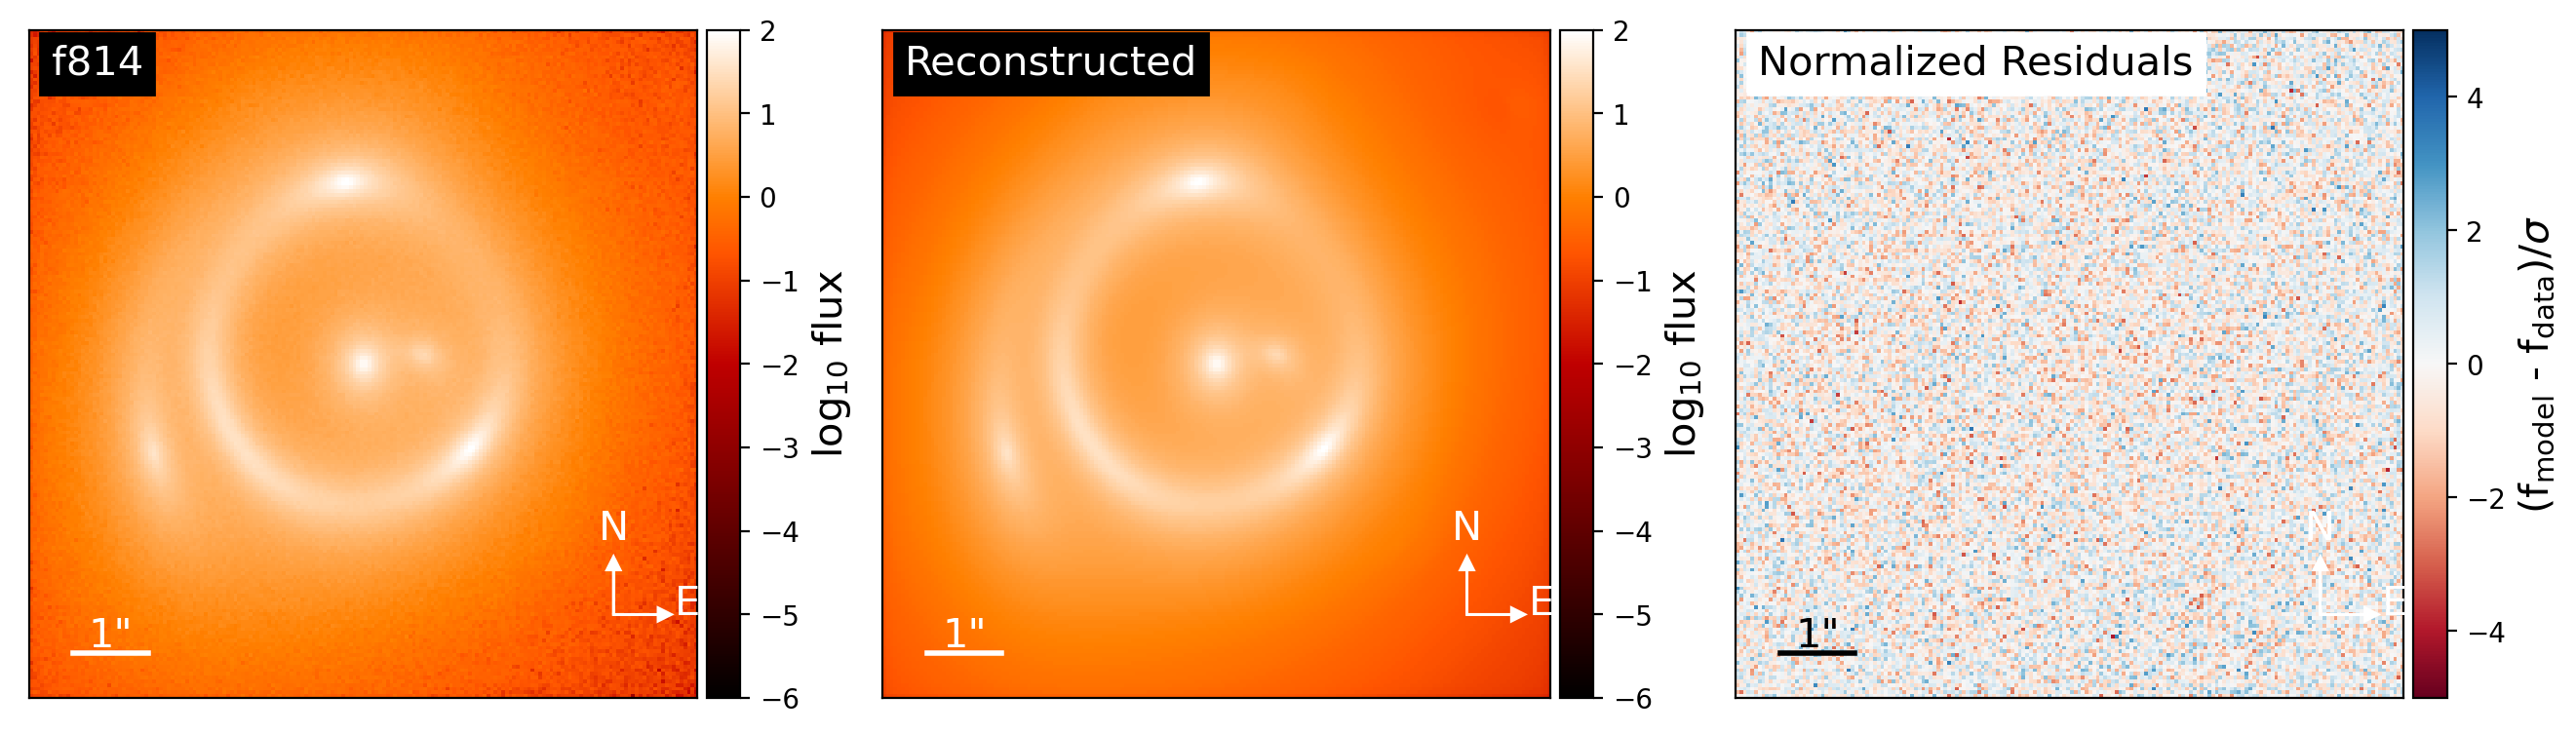

In [34]:
cmap = 'cubehelix'
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u
msh_cmap = 'RdBu'


lens_plot = ModelPlot([multi_band_list_out[0]], kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat", multi_band_type='single-band', linear_solver=True)
f, axes = plt.subplots(1, 3, figsize=(16, 16), sharex=False, sharey=True)
lens_plot.data_plot(ax=axes[0], band_index=0, v_max= 2, v_min=-6, text=str('f814'))
lens_plot.model_plot(ax=axes[1], band_index=0, v_max= 2, v_min=-6)
lens_plot.normalized_residual_plot(ax=axes[2], band_index=0, v_max=5, v_min=-5, cmap=msh_cmap)
#axes[1].plot(xtest, ytest, 'xb', markersize=10)
plt.show()
#plt.close()

-1.0003706838595745 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0003706838595745


/var/folders/fs/pvtv8t8x15gbvc9qcpcjbtjm0000gn/T/ipykernel_2667/2639136969.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/fs/pvtv8t8x15gbvc9qcpcjbtjm0000gn/T/ipykernel_2667/2639136969.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


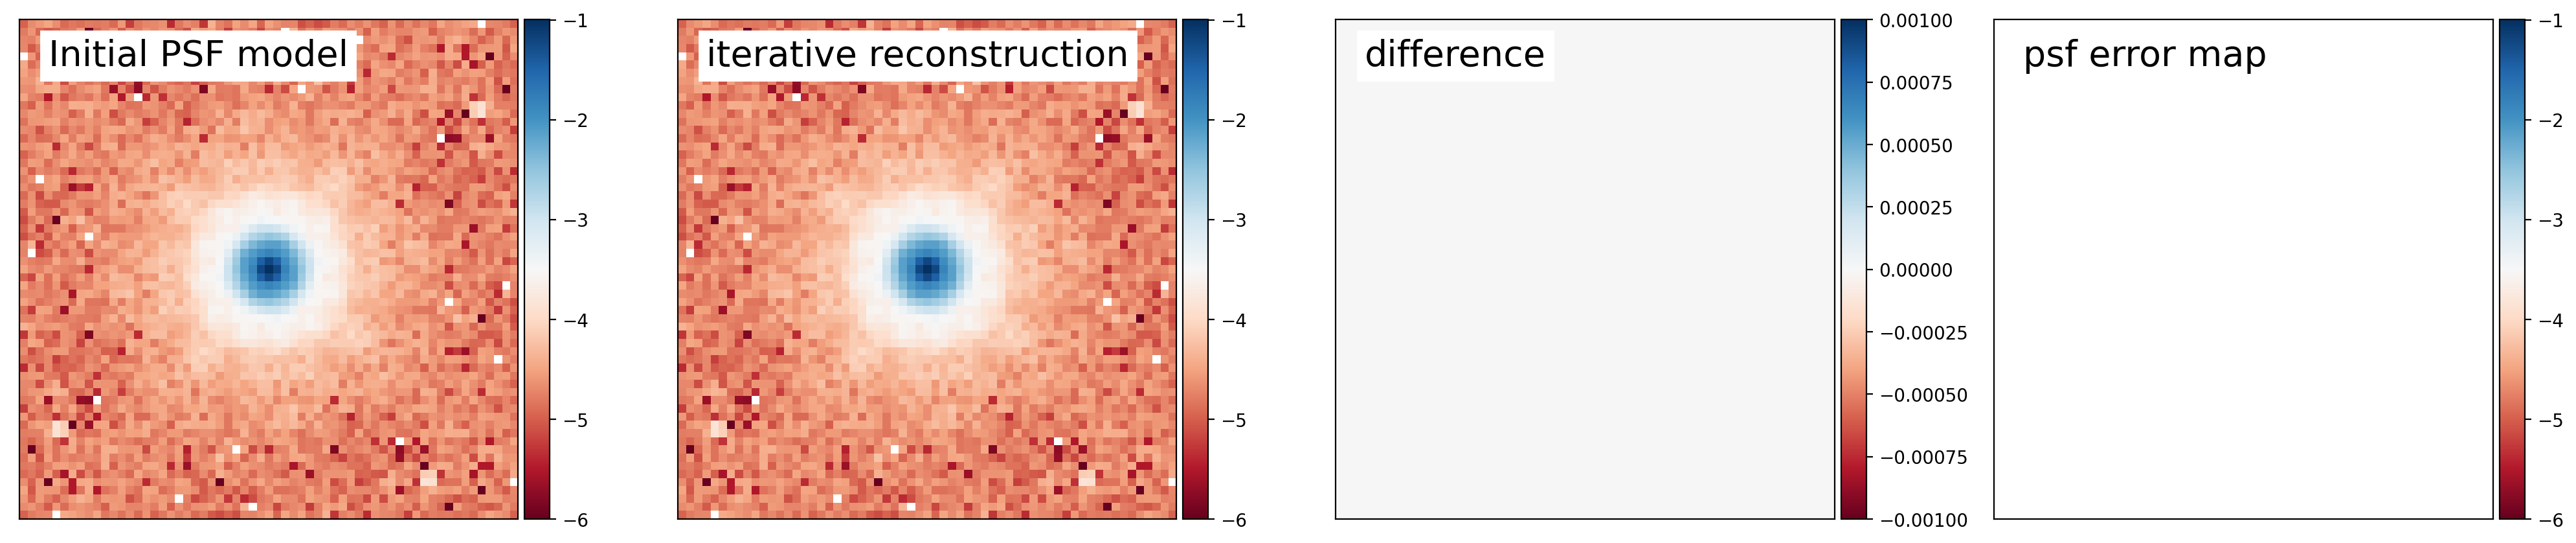

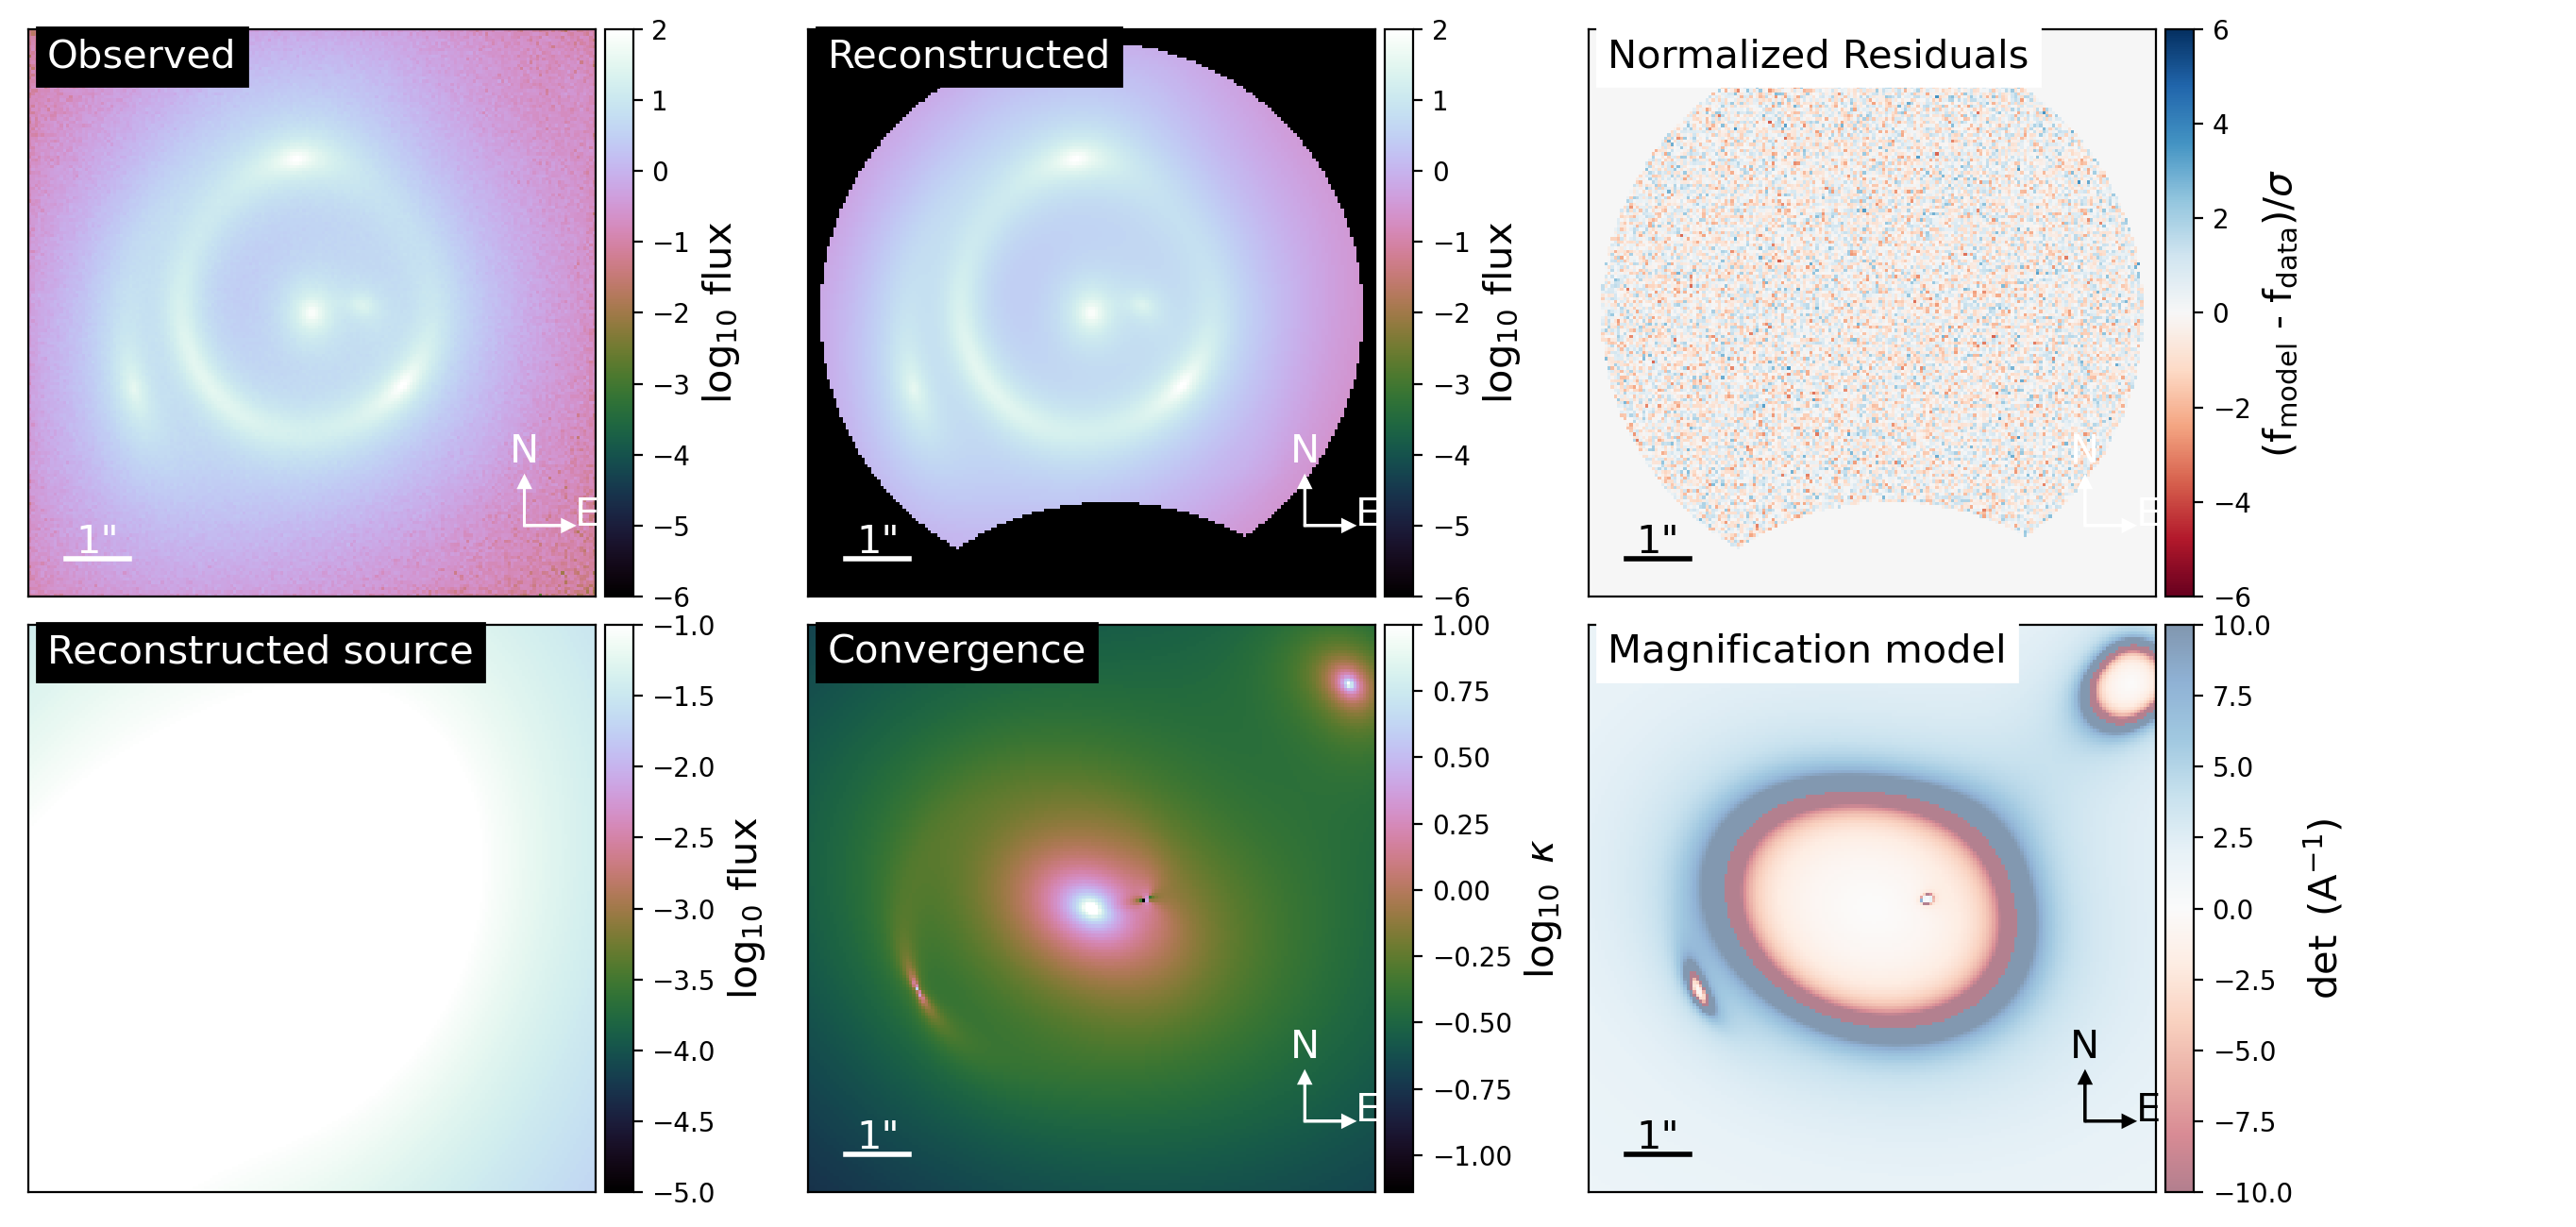

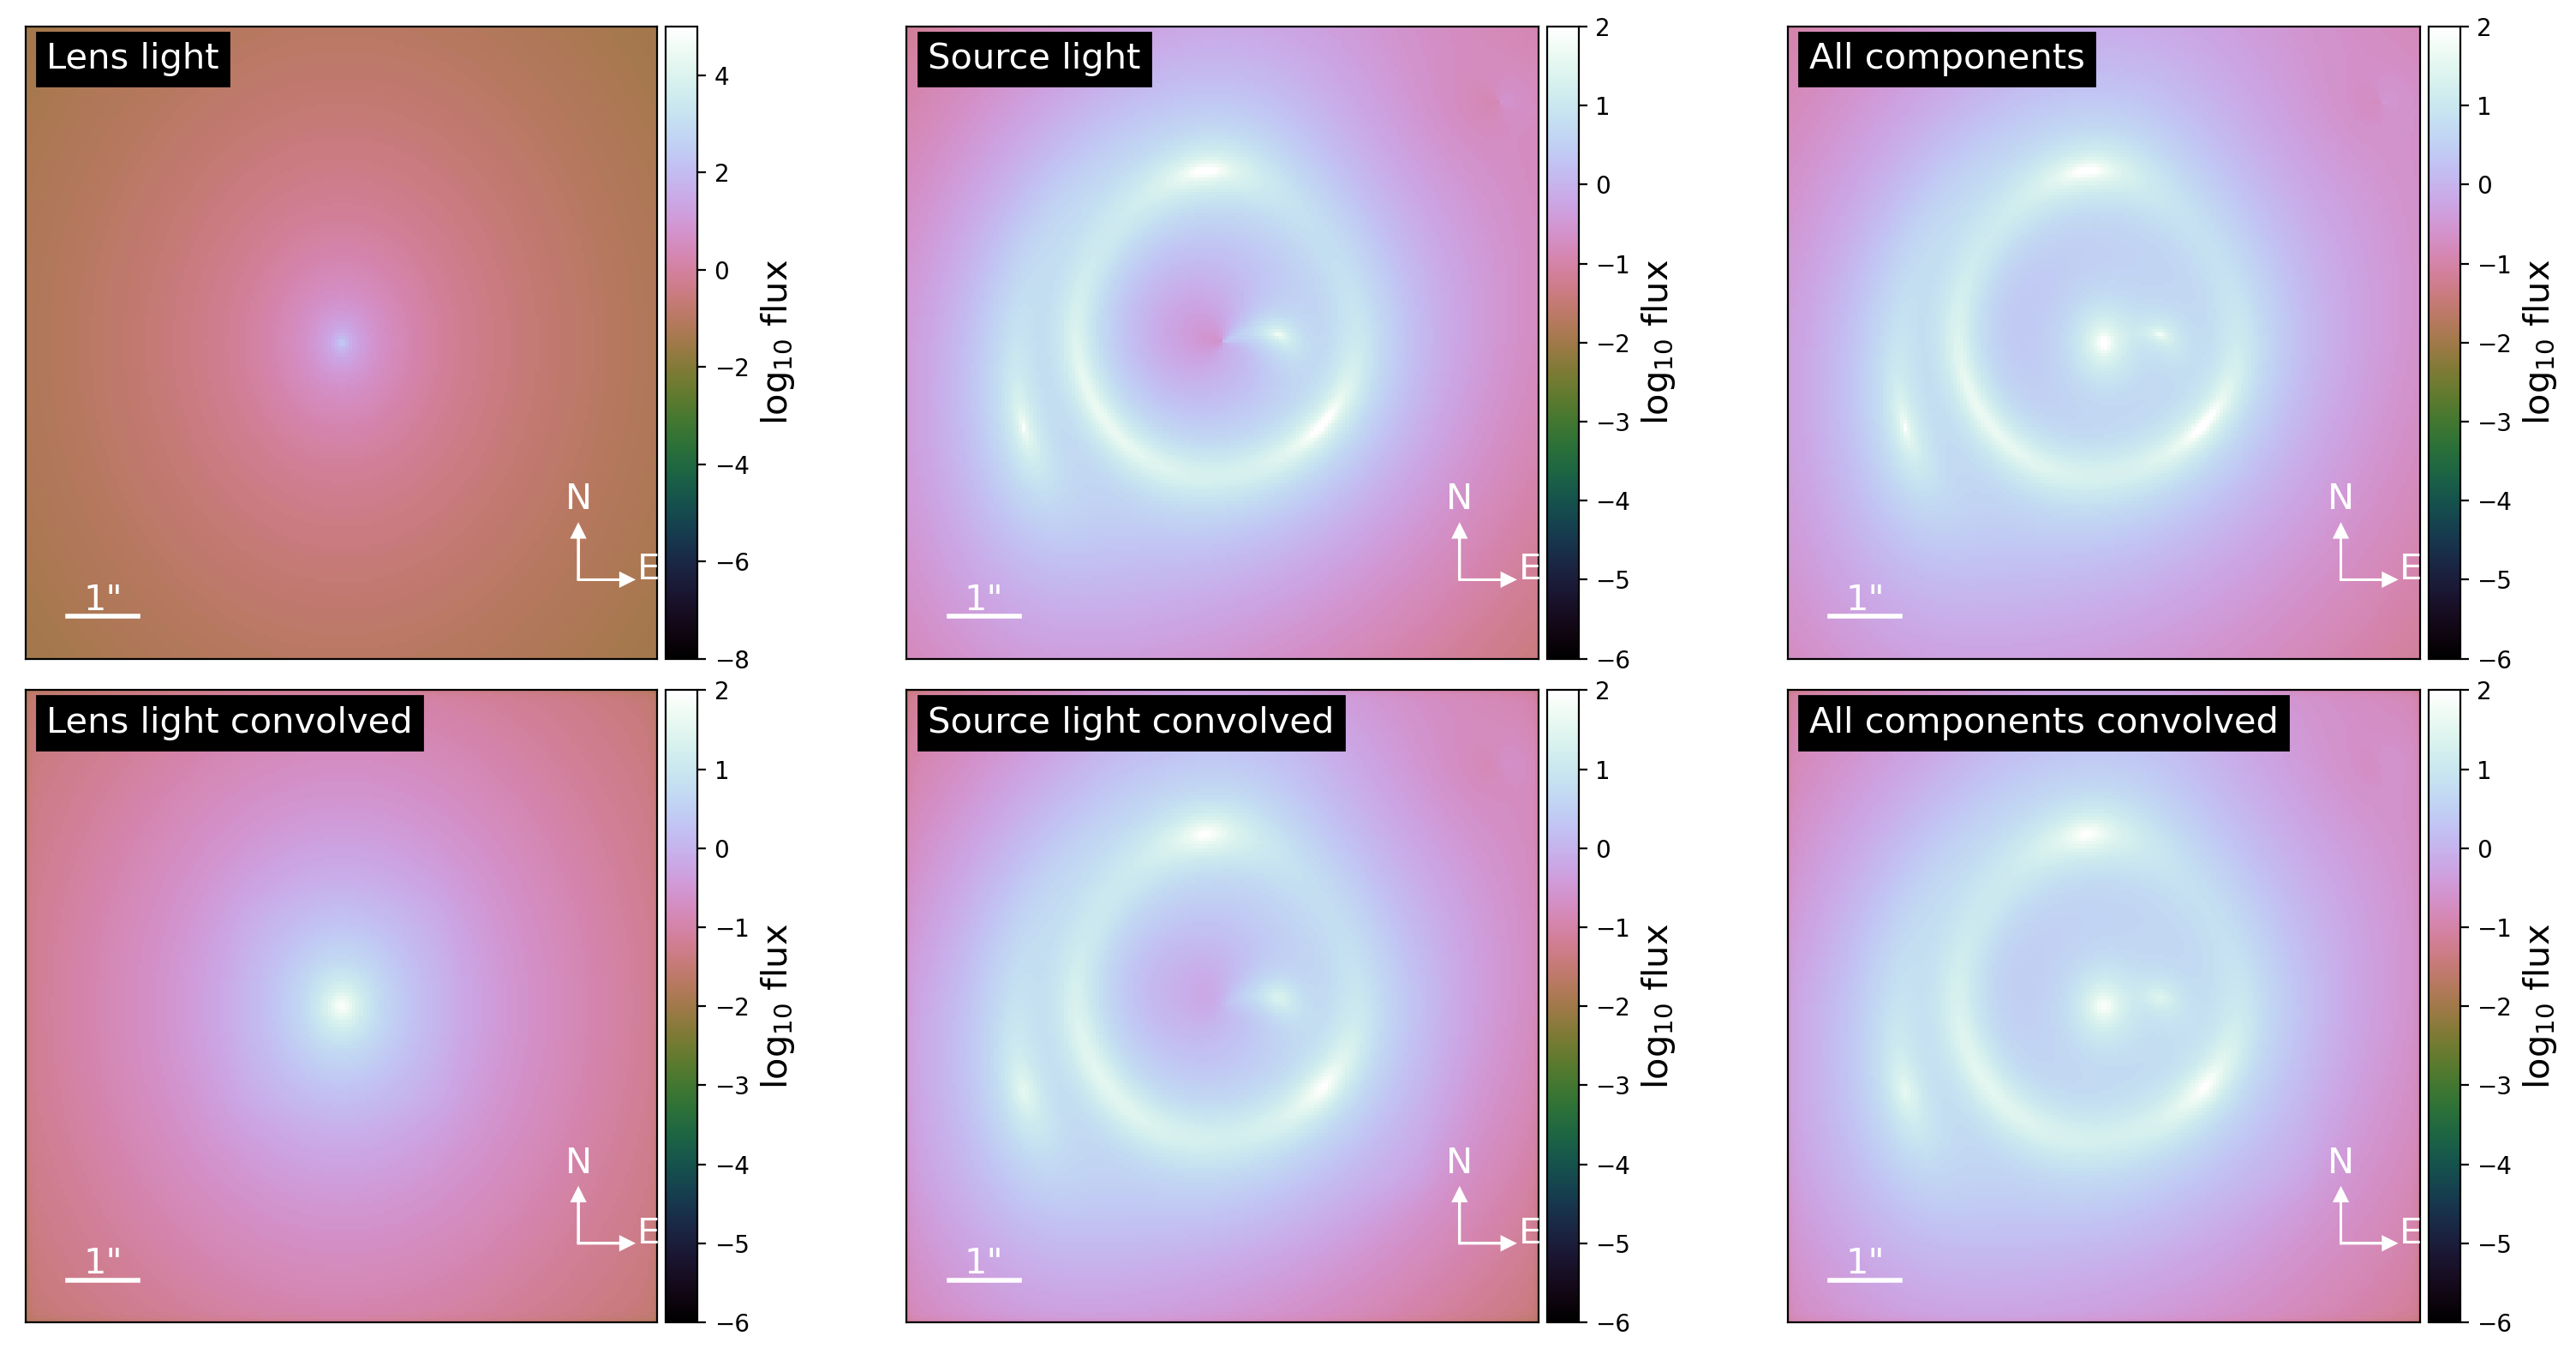

In [35]:
if analyse_output:
    band_i = 0
    
    lensPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string=cmap,
                    image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'],
                    multi_band_type='multi-linear',
                    linear_solver=True
                    )

    kwargs_psf = multi_band_list_out[band_i][1]
    kwargs_psf['kernel_point_source_init'] = kwargs_psf['kernel_point_source']
    
    from lenstronomy.Plots import chain_plot
    f, axes = chain_plot.psf_iteration_compare(kwargs_psf, vmin=-6, cmap=msh_cmap)
    f.show()
    
    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)
    lensPlot.data_plot(ax=axes[0,0], band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.model_plot(ax=axes[0,1], band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, band_index=band_i, cmap=msh_cmap)
    lensPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=200, band_index=band_i, v_min=-5, v_max=-1) 
    lensPlot.convergence_plot(ax=axes[1, 1], v_max=1, band_index=band_i)
    lensPlot.magnification_plot(ax=axes[1, 2], cmap=msh_cmap, band_index=band_i)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    
    #f, axes = plt.subplots(1, 1, figsize=(16, 8), sharex=False, sharey=False)
    #lensPlot.source_plot(ax=axes, deltaPix_source=0.01, numPix=200, band_index=band_i, v_min=-5, v_max=-1) 
    #plt.show()

    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)
    lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True, cmap=cmap, band_index=band_i, v_min=-8, v_max=5) 
    lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True, band_index=band_i, v_min=-6, v_max=2) 
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    
    lens_result, source_result, lens_light_result, ps_result = kwargs_result['kwargs_lens'], kwargs_result['kwargs_source'], kwargs_result['kwargs_lens_light'], kwargs_result['kwargs_ps']
    #print('lens', lens_result, "\n\n source", source_result, '\n\n lens light', lens_light_result, '\n\n ps', ps_result)


/var/folders/fs/pvtv8t8x15gbvc9qcpcjbtjm0000gn/T/ipykernel_2667/2523451966.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


107212 140 35
theta_E_lens0 2.0104 ± 0.0148
gamma_lens0 2.0010 ± 0.0029
e1_lens0 0.0999 ± 0.0005
e2_lens0 -0.0997 ± 0.0005
center_x_lens0 0.0003 ± 0.0004
center_y_lens0 0.0001 ± 0.0004
theta_E_lens1 0.1048 ± 0.0080
center_x_lens1 -0.6611 ± 0.1447
center_y_lens1 -0.0163 ± 0.0176
theta_E_lens2 0.4921 ± 0.0086
center_x_lens2 3.4044 ± 0.3077
center_y_lens2 2.9192 ± 0.2630
R_sersic_source_light0 0.9948 ± 0.0251
n_sersic_source_light0 5.0196 ± 0.0457
e1_source_light0 -0.0992 ± 0.0021
e2_source_light0 0.1002 ± 0.0024
center_x_source_light0 0.1851 ± 0.0098
center_y_source_light0 0.4867 ± 0.0081
R_sersic_source_light1 1.0144 ± 0.0209
n_sersic_source_light1 3.0345 ± 0.0310
e1_source_light1 -0.2017 ± 0.0018
e2_source_light1 0.2025 ± 0.0015
center_x_source_light1 -0.7036 ± 0.0051
center_y_source_light1 -0.0076 ± 0.0049
R_sersic_lens_light0 1.3529 ± 0.0448
n_sersic_lens_light0 5.0913 ± 0.0865
e1_lens_light0 -0.1004 ± 0.0018
e2_lens_light0 0.0002 ± 0.0018
center_x_lens_light0 0.0006 ± 0.0003
center_

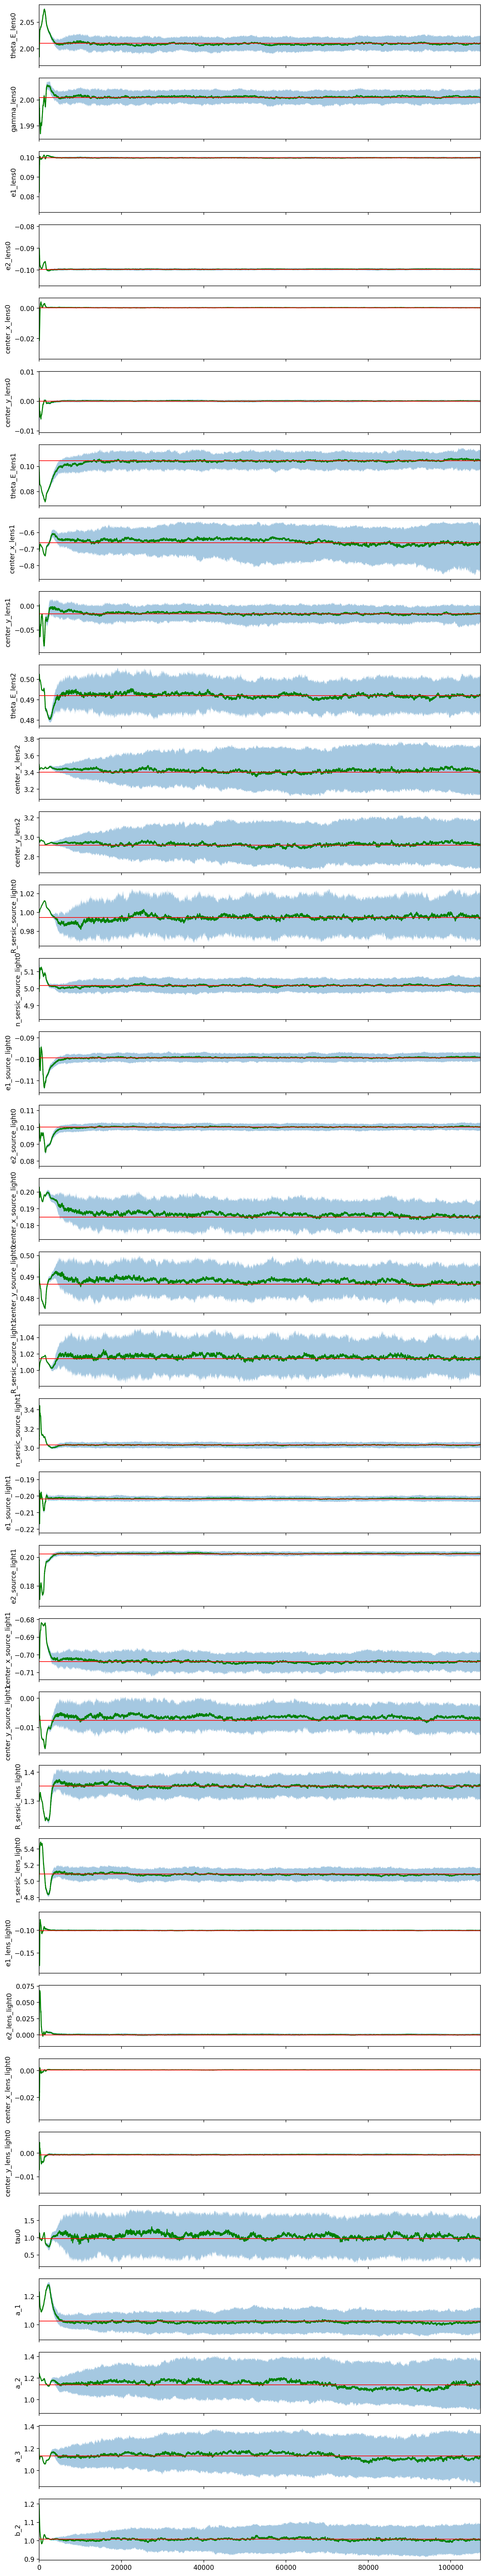

In [36]:
fit_output = chain_list
import time
if fit_output[-1][0] == 'EMCEE':
    samples_mcmc = fit_output[-1][1]
else:
    samples_mcmc = []
if not samples_mcmc == []:
    #samples_mcmc = samples_mcmc[:number,:]
    #samples_mcmc = np.array(samples_mcmc)
    n_params = samples_mcmc.shape[1]
    n_walkers = 4 * n_params
    n_step = int(samples_mcmc.shape[0] / n_walkers)
    print(n_step, n_walkers, n_params)
    chain = np.empty((n_walkers, n_step, n_params))
    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T
    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))
    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))
    burnin = -1
    last = n_step
    medians = []
    param_values = [#lens_name, 
                   median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                   median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2
                  ]
    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))
        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)
        medians.append(np.median(median_pos[i][burnin:last]))
    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        #fig.tight_layout()
        plt.show()
        fig.savefig(f'/Users/pierreboccard/Doc/EPFL/PDM/Files/notebooks/figures/Local/modellingsmallnew/run0708-mcmc-freecosmo/mcmc' + str(jobname) + '.jpg', dpi=250)

In [37]:
# from lenstronomy.Plots import chain_plot
# import corner

# param = fitting_seq.param_class
# param_array_truths = param.kwargs2args(kwargs_lens=kwargs_result.get('kwargs_lens'), kwargs_source=kwargs_result.get('kwargs_source'), kwargs_lens_light=kwargs_result.get('kwargs_lens_light'), kwargs_ps=kwargs_result.get('kwargs_ps'), kwargs_special=kwargs_result.get('kwargs_special'), kwargs_extinction=kwargs_result.get('kwargs_extinction'))

# sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]
# print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
# #print("parameters in order: ", param_mcmc)
# print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

# random_indices = np.random.choice(samples_mcmc.shape[0], 20000, replace=False)
# random_values = samples_mcmc[random_indices]

# print(samples_mcmc.shape)
# print(random_values.shape)
# #print(random_values[:40])

# n, num_param = np.shape(samples_mcmc)
# plot = corner.corner(random_values[:,:40], labels=param_mcmc[:40], show_titles=True, truths=param_array_truths[:40])
# plot.savefig(f'/Users/pierreboccard/Doc/EPFL/PDM/Files/notebooks/figures/Local/modellingsmall/run0627-mcmc-freecosmo/corner' + str(jobname) + '.jpg', dpi=250)